## Variable selection 7: SHAP values

This notebook goes with the blog post: Variable selection in Python, part II.

### Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, LeaveOneOut
import shap
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import svm
from sklearn.base import clone

In [2]:
font = {'size'   : 22}

plt.rc('font', **font)

### Data loading

In [3]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv').astype('float64')

In [4]:
data = data.loc[:, ['Production', 'Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform']]
data.head()

,Production,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
0,15.10,2.1,0.1,0.5,19.0,5.0,379.0,3.54
1,21.30,1.1,1.0,4.0,16.0,13.0,269.0,5.79
2,22.75,1.0,1.9,19.0,14.0,12.0,245.0,8.51
3,15.72,2.1,3.1,21.7,17.0,6.0,273.0,11.52
4,7.71,2.9,4.1,24.6,11.0,10.0,237.0,10.16


### SHAP values with Extra Trees (or Random Forest)

Github repo: https://github.com/slundberg/shap

Original paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6467492/pdf/nihms-1505578.pdf

Couple of articles with nice extra features / customizations:

https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/

https://meichenlu.com/2018-11-10-SHAP-explainable-machine-learning/

### Scaling features

How to use sklearn fit_transform with pandas and return dataframe instead of numpy array?

https://stackoverflow.com/a/35724176/1034648

In [5]:
X1 = data.drop('Production',axis=1)
scaled_X = preprocessing.StandardScaler().fit_transform(X1)
scaled_X_df = pd.DataFrame(scaled_X, index=X1.index, columns=X1.columns)

In [6]:
X, y = scaled_X_df, data['Production']

In [7]:
base_et = ExtraTreesRegressor(n_estimators=300,
                                n_jobs=-1,
                                bootstrap=True, # https://github.com/slundberg/shap/issues/556#issuecomment-484726256
                             oob_score=True)   

In [8]:
et = clone(base_et)
et.fit(X, y)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
          oob_score=True, random_state=None, verbose=0, warm_start=False)

#### Stability of Shapley Values and Multicolinearity

https://github.com/slundberg/shap/issues/288#issuecomment-435537334

In [9]:
explainer = shap.TreeExplainer(et, feature_dependence = 'tree_path_dependent')
shap_values = explainer.shap_values(X)

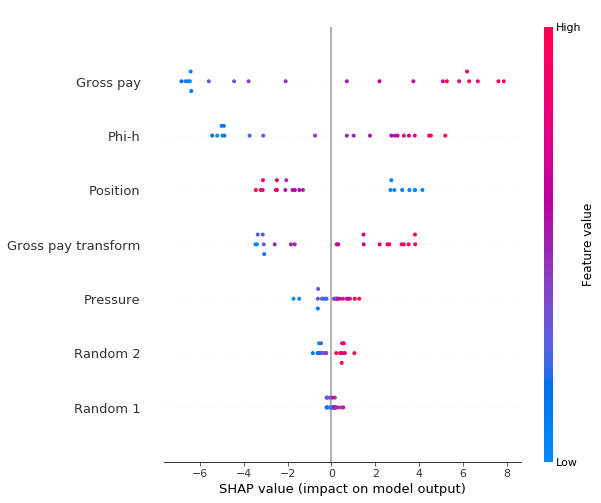

In [10]:
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show();

In [11]:
explainer = shap.TreeExplainer(et, X, feature_dependence = 'independent')
shap_values = explainer.shap_values(X)

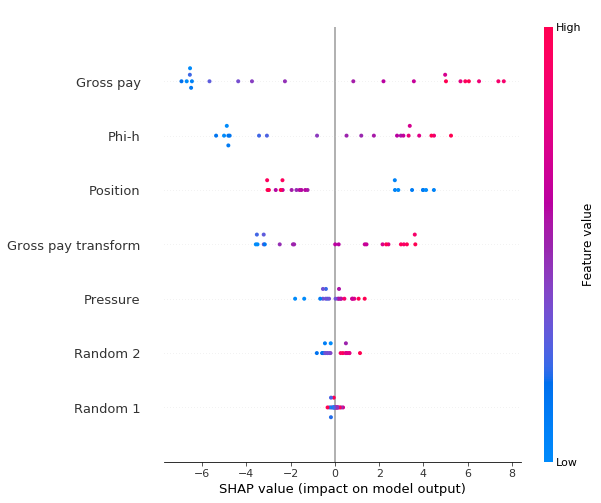

In [12]:
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show();

#### SHAP values with linear regression

In [13]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv').astype('float64')

In [14]:
data = data.loc[:, ['Production', 'Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform']]
data.head()

,Production,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
0,15.10,2.1,0.1,0.5,19.0,5.0,379.0,3.54
1,21.30,1.1,1.0,4.0,16.0,13.0,269.0,5.79
2,22.75,1.0,1.9,19.0,14.0,12.0,245.0,8.51
3,15.72,2.1,3.1,21.7,17.0,6.0,273.0,11.52
4,7.71,2.9,4.1,24.6,11.0,10.0,237.0,10.16


In [15]:
X, y = data.drop('Production',axis=1), data['Production']

In [16]:
LR= LinearRegression()
LR.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
explainer_L = shap.LinearExplainer(LR, X, feature_dependence="correlation")
shap_values = explainer_L.shap_values(X)

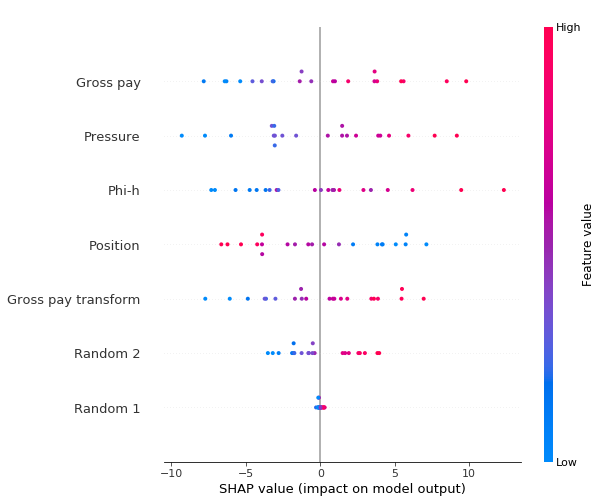

In [18]:
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show();

In [19]:
explainer_L = shap.LinearExplainer(LR, X, feature_dependence="independent")
shap_values = explainer_L.shap_values(X)

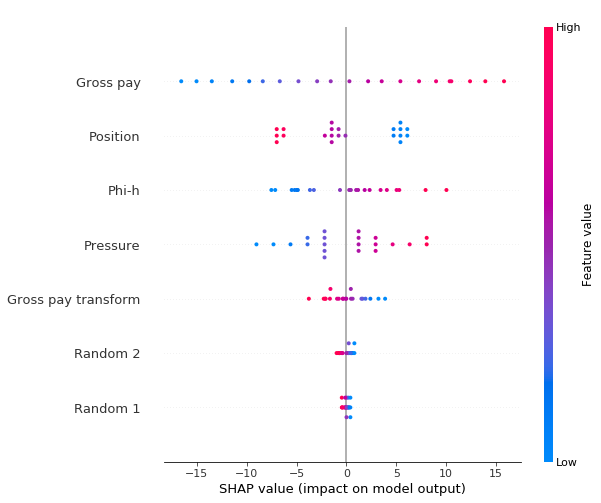

In [20]:
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show();

### How to pass best estimator:

https://github.com/slundberg/shap/issues/147

#### Could try SVM too with Kernel explainer

https://github.com/slundberg/shap/blob/master/README.md#model-agnostic-example-with-kernelexplainer-explains-any-function

This is the example for the issue with passing best estimator:
https://github.com/slundberg/shap/issues/811

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import shap
from sklearn import svm, preprocessing

url= 'https://raw.githubusercontent.com/mycarta/Data-science-tools-petroleum-exploration-and-production/master/Python/data/Table2_Hunt_2013_edit.csv'
data = pd.read_csv(url).astype('float64')

X = data.drop('Production',axis=1)
scaled_X = preprocessing.StandardScaler().fit_transform(X)
scaled_X_df = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)
y = data['Production']


SVM_regressor = svm.SVR(cache_size = 800)
loo = LeaveOneOut()

parm_grid={'C': [0.1, 0.5, 1, 3, 5, 7, 9, 11, 13, 15],
            'gamma':[0.0005, 0.0002, 0.0001, 0.001, 0.01, 0.1, 1, 2]}

grid_search = GridSearchCV(SVM_regressor,
                           param_grid=parm_grid,
                           scoring='neg_mean_squared_error',
                           cv=loo)
            
rgr = grid_search.fit(scaled_X_df, y)

r = rgr.best_estimator_

explainer = shap.KernelExplainer(r, scaled_X_df)
shap_values = explainer.shap_values(scaled_X_df)

Provided model function fails when applied to the provided data set.


TypeError: 'SVR' object is not callable

__OK, trying suggestion from here:__
https://github.com/slundberg/shap/issues/506#issuecomment-475891144

In [ ]:
url= 'https://raw.githubusercontent.com/mycarta/Data-science-tools-petroleum-exploration-and-production/master/Python/data/Table2_Hunt_2013_edit.csv'
data = pd.read_csv(url).astype('float64')

In [ ]:
data = data.loc[:, ['Production', 'Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform']]

In [ ]:
X, y = data.drop('Production',axis=1), data['Production']

In [ ]:
X = data.drop('Production',axis=1)
scaled_X = preprocessing.StandardScaler().fit_transform(X)
scaled_X_df = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)

In [ ]:
SVM_regressor = svm.SVR(cache_size = 800)

In [22]:
loo = LeaveOneOut()

In [23]:
parm_grid={'C': [0.1, 0.5, 1, 3, 5, 7, 9, 11, 13, 15],
            'gamma':[0.0005, 0.0002, 0.0001, 0.001, 0.01, 0.1, 1, 2]}


grid_search = GridSearchCV(SVM_regressor,
                           param_grid=parm_grid,
                           scoring='neg_mean_squared_error',
                           cv=loo)
            
rgr = grid_search.fit(scaled_X_df, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

rgr.best_estimator_

Best score: -23.534593536717228
Best parameters: {'C': 15, 'gamma': 0.1}


SVR(C=15, cache_size=800, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [24]:
s = rgr.best_estimator_.fit(scaled_X_df,y).predict

In [25]:
explainer = shap.KernelExplainer(s, scaled_X_df)
shap_values = explainer.shap_values(scaled_X_df, l1_reg = 0.5)

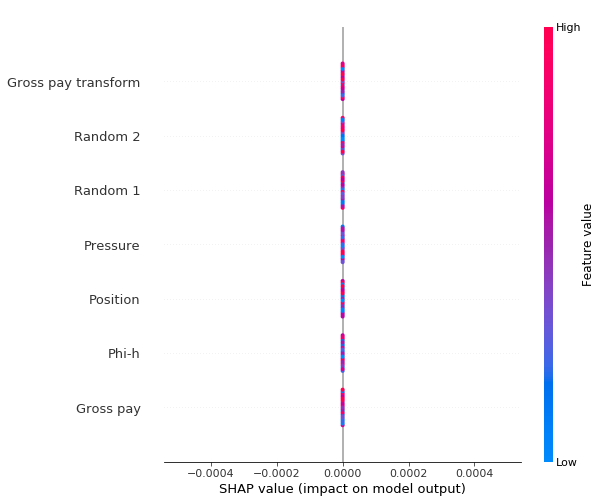

In [26]:
#shap.summary_plot(shap_values, val_X, show=False)
shap.summary_plot(shap_values, scaled_X_df, show=False)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show();

__Weird!!! All aligned__

In [27]:
svr_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
svrp = svr_poly.fit(scaled_X_df,y).predict

In [28]:
explainer = shap.KernelExplainer(svrp, scaled_X_df)
shap_values = explainer.shap_values(scaled_X_df, l1_reg=0.5)

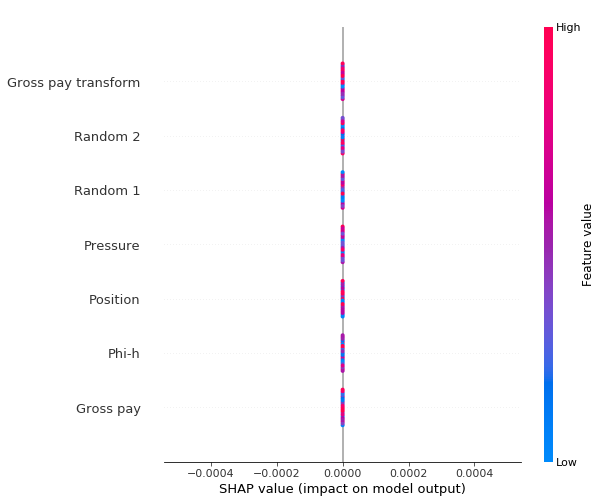

In [29]:
#shap.summary_plot(shap_values, val_X, show=False)
shap.summary_plot(shap_values, scaled_X_df, show=False)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show();

In [30]:
train_X, val_X, train_y, val_y = train_test_split(scaled_X_df, y, test_size= 0.3, random_state=99)

In [53]:
SVM_regressor = svm.SVR(kernel='rbf', cache_size = 800)
svrr = SVM_regressor.fit(train_X, train_y).predict
explainer = shap.KernelExplainer(svrr, scaled_X_df)
shap_values = explainer.shap_values(val_X, l1_reg= 0.5)

C:\Users\mniccoli\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


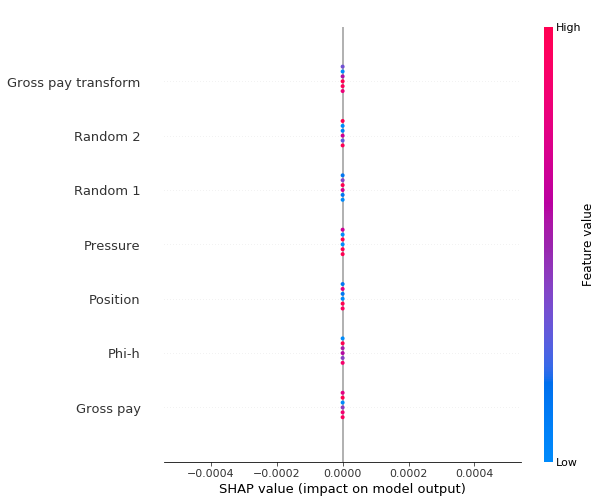

In [54]:
#shap.summary_plot(shap_values, val_X, show=False)
shap.summary_plot(shap_values, val_X, show=False)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show();